In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
import sys

In [2]:
def load_wcs_from_file(filename):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed an NAXIS=2 image here.
    # The pixel coordinates are pairs of [X, Y].
    # The "origin" argument indicates whether the input coordinates
    # are 0-based (as in Numpy arrays) or
    # 1-based (as in the FITS convention, for example coordinates
    # coming from DS9).
    pixcrd = np.array([[0, 0], [24, 38], [45, 98]], dtype=np.float64)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin" -- in this case we're declaring we
    # have 0-based (Numpy-like) coordinates.
    world = w.wcs_pix2world(pixcrd, 0)
    print(world)

    # Convert the same coordinates back to pixel coordinates.
    pixcrd2 = w.wcs_world2pix(world, 0)
    print(pixcrd2)

    # These should be the same as the original pixel coordinates, modulo
    # some floating-point error.
    assert np.max(np.abs(pixcrd - pixcrd2)) < 1e-6

    # The example below illustrates the use of "origin" to convert between
    # 0- and 1- based coordinates when executing the forward and backward
    # WCS transform.
    x = 0
    y = 0
    origin = 0
    assert (w.wcs_pix2world(x, y, origin) ==
            w.wcs_pix2world(x + 1, y + 1, origin + 1))

In [4]:
load_wcs_from_file('Holmes Data/2010-04-16-holmes-dedup/holmes-0003.wcs')


[[54.43841229 51.30068844]
 [54.51921066 51.25101878]
 [54.6555331  51.19850061]]
[[8.52651283e-13 3.63797881e-12]
 [2.40000000e+01 3.80000000e+01]
 [4.50000000e+01 9.80000000e+01]]


In [5]:
load_wcs_from_file('Holmes Data/2010-04-16-holmes-dedup/holmes-0004.wcs')


[[50.96453984 51.4713486 ]
 [51.12820109 51.31065139]
 [51.27052259 51.05638841]]
[[7.95807864e-13 2.58637556e-12]
 [2.40000000e+01 3.80000000e+01]
 [4.50000000e+01 9.80000000e+01]]


TypeError: Image data of dtype <U51 cannot be converted to float

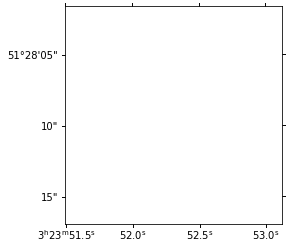

In [8]:
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename

filename = get_pkg_data_filename('Holmes Data/2010-04-16-holmes-dedup/holmes-0004.wcs')

hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)

fig = plt.figure()
fig.add_subplot(111, projection=wcs)
plt.imshow('Holmes Data/2010-04-16-holmes-dedup/holmes-0004.jpg', origin='lower', cmap=plt.cm.viridis)
plt.xlabel('RA')
plt.ylabel('Dec')